In [12]:
from typing import Tuple
import pandas as pd
from tqdm.notebook import tqdm
import sys
sys.path.append('..')
from evaluation.generated_dataset import GeneratedDataset, load_all_from_config
from evaluation.novelty import NoveltyFilter, filter_by_unique_structure

In [13]:
datasets = {
    "WyckoffTransformer": ("WyckoffTransformer",),
    "WyckoffLLM-naive": ("WyckoffLLM-naive",)
}

In [14]:
all_datasets = load_all_from_config(
    datasets=list(datasets.values()) + [("split", "train"), ("split", "val"), ("split", "test")],
    dataset_name="mp_20")

In [15]:
novelty_reference = pd.concat([
    all_datasets[('split', 'train')].data,
    all_datasets[('split', 'val')].data], axis=0, verify_integrity=True)
novelty_filter = NoveltyFilter(novelty_reference)

In [16]:
import evaluation.statistical_evaluator
test_evaluator = evaluation.statistical_evaluator.StatisticalEvaluator(all_datasets[('split', 'test')].data)

In [17]:
train_w_template_set = frozenset(novelty_reference.apply(
    evaluation.novelty.record_to_anonymous_fingerprint, axis=1))

In [18]:
table = pd.DataFrame(
    index=datasets.keys(), columns=[
        "Novelty (%)", "Structural", "Compositional", 
        "Recall", "Precision",
        r"$\rho$", "$E$", "# Elements",
        "S.U.N. (%)",
        "Novel Template (%)", "P1 (%)",
        "Space Group", "S.S.U.N. (%)"])
table.index.name = "Method"
E_hull_threshold = 0.08

for name, transformations in tqdm(datasets.items()):
    dataset = all_datasets[transformations]
    unique = filter_by_unique_structure(dataset.data)
    print(len(unique), len(dataset.data), len(unique) / len(dataset.data))
    novel_template = ~unique.apply(evaluation.novelty.record_to_anonymous_fingerprint, axis=1).isin(train_w_template_set)
    table.loc[name, "Novel Template (%)"] = 100 * novel_template.mean()
    novel = novelty_filter.get_novel(unique)
    table.loc[name, "Novelty (%)"] = 100 * len(novel) / len(unique)
    if "structural_validity" in novel.columns:
        table.loc[name, "Structural"] = 100 * novel.structural_validity.mean()
    table.loc[name, "Compositional"] = 100 * novel.smact_validity.mean()
    if "cdvae_crystal" in novel.columns:
        cov_metrics = test_evaluator.get_coverage(novel.cdvae_crystal)    
        table.loc[name, "Recall"] = 100 * cov_metrics["cov_recall"]
        table.loc[name, "Precision"] = 100 * cov_metrics["cov_precision"]
        novel = novel[novel.structural_validity]
        table.loc[name, r"$\rho$"] = test_evaluator.get_density_emd(novel)
        table.loc[name, "$E$"] = test_evaluator.get_cdvae_e_emd(novel)
        table.loc[name, "# Elements"] = test_evaluator.get_num_elements_emd(novel)
    table.loc[name, "P1 (%)"] = 100 * (novel.group == 1).mean()
    # table.loc[name, "# DoF"] = test_evaluator.get_dof_emd(novel)
    table.loc[name, "Space Group"] = test_evaluator.get_sg_chi2(novel)
    #try:
    #    table.loc[name, "SG preserved (%)"] = 100 * is_sg_preserved(novel.spacegroup_number, transformations).mean()
    #except KeyError:
    #    pass
    #table.loc[name, "Elements"] = test_evaluator.get_elements_chi2(novel)
    if "corrected_chgnet_ehull" in novel.columns:
        # S.U.N. is measured with respect to the initial structures
        has_ehull = dataset.data.corrected_chgnet_ehull.notna().sum()
        is_sun = (novel.corrected_chgnet_ehull <= E_hull_threshold)
        table.loc[name, "S.U.N. (%)"] = 100 * is_sun.sum() / has_ehull.sum()
        table.loc[name, "S.S.U.N. (%)"] = 100 * (is_sun & (novel.group != 1)).sum() / has_ehull.sum()

  0%|          | 0/2 [00:00<?, ?it/s]

9887 10000 0.9887
91 91 1.0


In [19]:
table

,Novelty (%),Structural,Compositional,Recall,Precision,$\rho$,$E$,# Elements,S.U.N. (%),Novel Template (%),P1 (%),Space Group,S.S.U.N. (%)
Method,,,,,,,,,,,,,
WyckoffTransformer,90.674623,NaN,81.63971,NaN,NaN,NaN,NaN,NaN,NaN,23.596642,1.952036,0.056771,NaN
WyckoffLLM-naive,96.703297,NaN,78.409091,NaN,NaN,NaN,NaN,NaN,NaN,47.252747,1.136364,6.26218,NaN


In [20]:
mp_20 = pd.concat([
    GeneratedDataset.from_cache(('split', 'train'), 'mp_20').data,
    GeneratedDataset.from_cache(('split', 'val'), 'mp_20').data,
    GeneratedDataset.from_cache(('split', 'test'), 'mp_20').data],
    axis=0)
import numpy as np
mp_20_sgs = np.histogram(mp_20.spacegroup_number, bins=range(1, 231))

In [28]:
generated = dict(zip([x[0] for x in all_datasets.keys()], [x.data for x in all_datasets.values()]))

In [30]:
sg_order = np.argsort(mp_20_sgs[0])[::-1]
wyformer_sgs = np.histogram(generated['WyckoffTransformer'].spacegroup_number, bins=range(1, 231))
wyllm_sgs = np.histogram(generated['WyckoffLLM-naive'].spacegroup_number, bins=range(1, 231))

In [34]:
import pyxtal
from matplotlib import pyplot as plt

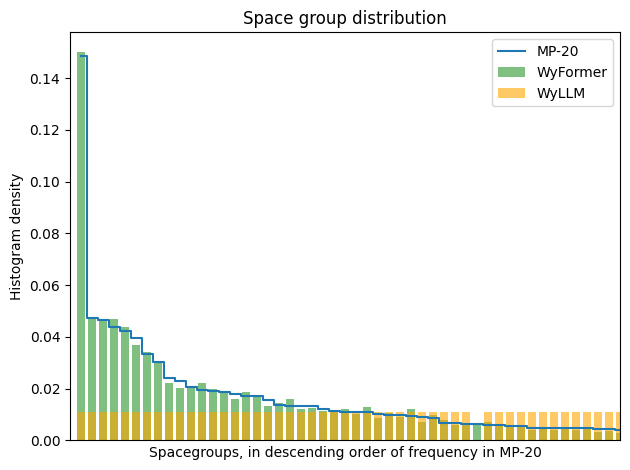

In [45]:
fig, ax = plt.subplots()


ax.bar(wyformer_sgs[1][:-1], wyformer_sgs[0][sg_order] / wyformer_sgs[0].sum(), alpha=0.5, label='WyFormer', color='green')
ax.bar(wyllm_sgs[1][:-1], wyllm_sgs[0][sg_order] / wyllm_sgs[0].sum(), alpha=0.6, label='WyLLM', color='orange')
ax.step(mp_20_sgs[1][:-1], mp_20_sgs[0][sg_order] / mp_20_sgs[0].sum(), label='MP-20', where='mid')
chosen_groups_ticks = (wyllm_sgs[0][sg_order] / wyllm_sgs[0].sum() > 0.03)
ax.set_xticks(np.arange(1, 230)[chosen_groups_ticks])
ax.set_xticklabels([pyxtal.Group(g).symbol for g in np.arange(1, 230)[sg_order][chosen_groups_ticks]], rotation=90)
ax.set_xlabel('Spacegroups, in descending order of frequency in MP-20')
ax.set_xlim(0, 50)
ax.set_ylabel('Histogram density')
ax.set_title('Space group distribution')
ax.legend()
fig.tight_layout()
fig.savefig('../plots/ICLR_rebuttal/space_groups_wt_vs_wyllm_top50.pdf');